# Planetary embryos in the inner Solar System

In this example we will simulate the dynamics of a group of [planetary embryos](https://en.wikipedia.org/wiki/Protoplanet) in the inner Solar System, tracking their close encounters via heyoka.py's [event detection](<./Event detection.ipynb>) system.

Current theories of planet formation posit that planetary embryos form via the collision of kilometer-sized [planetesimals](https://en.wikipedia.org/wiki/Planetesimal), which in turn originate from the aggregation of dust in protoplanetary disks. Planetary embryos have masses of about $10^{22}$ to $10^{23}\,\mathrm{kg}$, and they have diameters up to a few thousand kilometers. Over the course of hundreds of millions of years, planetary embryos are thought to collide with each other, eventually resulting in the formation of planets.

In this tutorial we will consider a system consisting of a Sun-like star and 30 embryos distributed on planar orbits with semi-major axes ranging from $0.5$ to $1.2\,\mathrm{AU}$. The embryos have masses between $0.2$ Earth masses and $0.6$ Lunar masses and the dynamics is purely gravitational (i.e., there's no protoplanetary disk and no [planetary migration](https://en.wikipedia.org/wiki/Planetary_migration) takes place). The setup is inspired by [this paper](https://ui.adsabs.harvard.edu/abs/1999MNRAS.304..793C/abstract).

## Constants and initial conditions

Let us begin by defining a couple of constants:

In [1]:
# Total number of embryos.
N_embryos = 30

# Gravitational constant.
G = 0.01720209895 * 0.01720209895 * 365 * 365

We will be using Solar masses, astronomical units and years as units of measure.

Initially the embryos are placed on randomly-generated low-eccentricity planar orbits. The semi-major axes of the orbits are equispaced between $0.5$ and $1.2\,\mathrm{AU}$, and the embryo masses decrease with the distance $r$ from the Sun following the power law

$$
4.32\cdot 10^{-8}r^{-3.8},
$$

so that the innermost embryo has a mass of $0.2$ Earth masses while the outermost embryo has a mass of $0.6$ Lunar masses.

In [2]:
import pykep as pk
import random
import numpy as np

# Set the global random seed.
random.seed(42)

# Init the vector of masses with the
# mass of the Sun.
masses = [1.]

# Init the initial conditions of the system
# with the state vector of the Sun (placed in
# the origin with zero velocity).
ic = [0.] * 6

# Add the embryos.
for a in np.linspace(0.5, 1.2, N_embryos):
    r, v = pk.par2ic([a,
                      # Random low eccentricity.
                      random.uniform(0, 0.01),
                      # Planar orbit.
                      0.,
                      # Random angular orbital elements.
                      random.uniform(0, 2*np.pi),
                      random.uniform(0, 2*np.pi),
                      random.uniform(0, 2*np.pi)], G)

    # Append the randomly-generated
    # Cartesian initial conditions.
    ic += list(r)
    ic += list(v)
    
    # Compute the mass.
    masses.append(4.32e-8*a**(-3.8))

We are now ready to create the differential equations for this dynamical system via heyoka.py's ``model.nbody()`` helper:

In [3]:
import heyoka as hy

sys = hy.model.nbody(N_embryos + 1, masses = masses, Gconst = G)

## Tracking close encounters

In order to track close encounters between embryos we will be using heyoka.py's [event detection](<./Event detection.ipynb>) system to track over time the minima of the distances between each pair of embryos. The mutual distance $D_{ij}\left( t \right)$ between embryos $i$ and $j$ is at a local minimum when its time derivative,

$$
\frac{dD_{ij}\left( t \right)}{dt}  = 2\left[ x_i\left( t \right) - x_j\left( t \right) \right]\left[ v_{xi}\left( t \right) - v_{xj}\left( t \right) \right] 
 +2\left[ y_i\left( t \right) - y_j\left( t \right) \right]\left[ v_{yi}\left( t \right) - v_{yj}\left( t \right) \right]
 +2\left[ z_i\left( t \right) - z_j\left( t \right) \right]\left[ v_{zi}\left( t \right) - v_{zj}\left( t \right) \right],
$$

is zero. Thus, by defining the event equation

$$
\frac{dD_{ij}\left( t \right)}{dt} = 0
$$

we will be able to detect and keep track of the close encounters between embryos.

Let us see the definition of the event callback:

In [4]:
# List of minima for the mutual
# embryo distances.
ce_list = []

# The event callback.
class ce_cb:
    def __init__(self, i, j):
        self.i = i
        self.j = j
    def __call__(self, ta, time, d_sgn):
        # Compute the state of the system
        # at the point of minimum distance.
        # between embryos i and j.
        ta.update_d_output(time)
        
        # Extract the position vectors
        # for embryos i and j.
        st = ta.d_output.reshape(-1, 6)
        ri = st[self.i, 0:3]
        rj = st[self.j, 0:3]

        # Append to ce_list:
        # - the time at which the minimum is reached,
        # - the indices of the embryos,
        # - the distance between the embryos.
        ce_list.append((time, self.i, self.j, np.linalg.norm(ri - rj)))

We can now proceed to the creation of the events:

In [5]:
# The list of events.
evs = []

# Iterate over all the embryo-embryo pairs.
# NOTE: the body at index 0 is the Sun, start
# from index 1.
for i in range(1, N_embryos + 1):
    xi, yi, zi = hy.make_vars("x_{}".format(i), "y_{}".format(i), "z_{}".format(i))
    vxi, vyi, vzi = hy.make_vars("vx_{}".format(i), "vy_{}".format(i), "vz_{}".format(i))

    for j in range(i + 1, N_embryos + 1):
        xj, yj, zj = hy.make_vars("x_{}".format(j), "y_{}".format(j), "z_{}".format(j))
        vxj, vyj, vzj = hy.make_vars("vx_{}".format(j), "vy_{}".format(j), "vz_{}".format(j))
        
        # The event equation.
        eq = (xi-xj)*(vxi-vxj) + (yi-yj)*(vyi-vyj) + (zi-zj)*(vzi-vzj)
        
        # Create the event and append it to
        # the event list.
        evs.append(hy.nt_event(eq, ce_cb(i, j), direction = hy.event_direction.positive))

Note how we specified a *positive* direction for the events. This means that the event is detected only when the value of ${dD_{ij}\left( t \right)}/{dt}$ switches from negative to positive (and not viceversa). In other words, by specifying a positive event direction we will be filtering out the maxima of $D_{ij}\left( t \right)$, retaining only the minima.

We are now ready to create the integrator. In order to curb the compilation time, we will activate the ``compact_mode`` option. We will also use a relatively high tolerance of $10^{-9}$, since in this situation we are not interested in being accurate to machine precision:

In [6]:
ta = hy.taylor_adaptive(sys, ic, tol = 1e-9, compact_mode = True,
                        # The list of non-terminal events.
                        nt_events = evs)

## Running the numerical integration

Before proceeding with the integration, we will, as usual, re-centre the system so that the centre of mass is in the origin with zero velocity:

In [7]:
# Reshape for ease of indexing.
st = ta.state.reshape(-1, 6)

# Compute the position of the COM.
com_x = np.sum(st[:, 0]*masses)/np.sum(masses)
com_y = np.sum(st[:, 1]*masses)/np.sum(masses)
com_z = np.sum(st[:, 2]*masses)/np.sum(masses)

# Compute the velocity of the COM.
com_vx = np.sum(st[:, 3]*masses)/np.sum(masses)
com_vy = np.sum(st[:, 4]*masses)/np.sum(masses)
com_vz = np.sum(st[:, 5]*masses)/np.sum(masses)

# Recentre.
st[:, 0] -= com_x
st[:, 1] -= com_y
st[:, 2] -= com_z
st[:, 3] -= com_vx
st[:, 4] -= com_vy
st[:, 5] -= com_vz

We can now proceed with the numerical integration:

In [8]:
from tqdm.auto import tqdm

# Progressbar callback.
class cb:
    def __init__(self, tot):
        self.pbar = tqdm(total = tot, unit_scale=True)
        self.cur = 0.
        self.tot = tot
    def __call__(self, ta):
        dt = ta.time - self.cur
        self.pbar.update(ta.time - self.cur)
        self.cur += dt
        
        return True

# Integrate over a regular time grid
# up to 10000 years.
final_t = 10000.
t_grid = np.linspace(0, final_t, 10000)
_, _, _, _, _, out = ta.propagate_grid(t_grid, callback = cb(final_t))

  0%|          | 0.00/10.0k [00:00<?, ?it/s]

## Results

Let us build a list of the distance minima detected during the integration:

In [9]:
ce_dist = np.array(list(t[-1] for t in ce_list))

We can now plot the cumulative number of close encounters as a function of distance of closest approach:

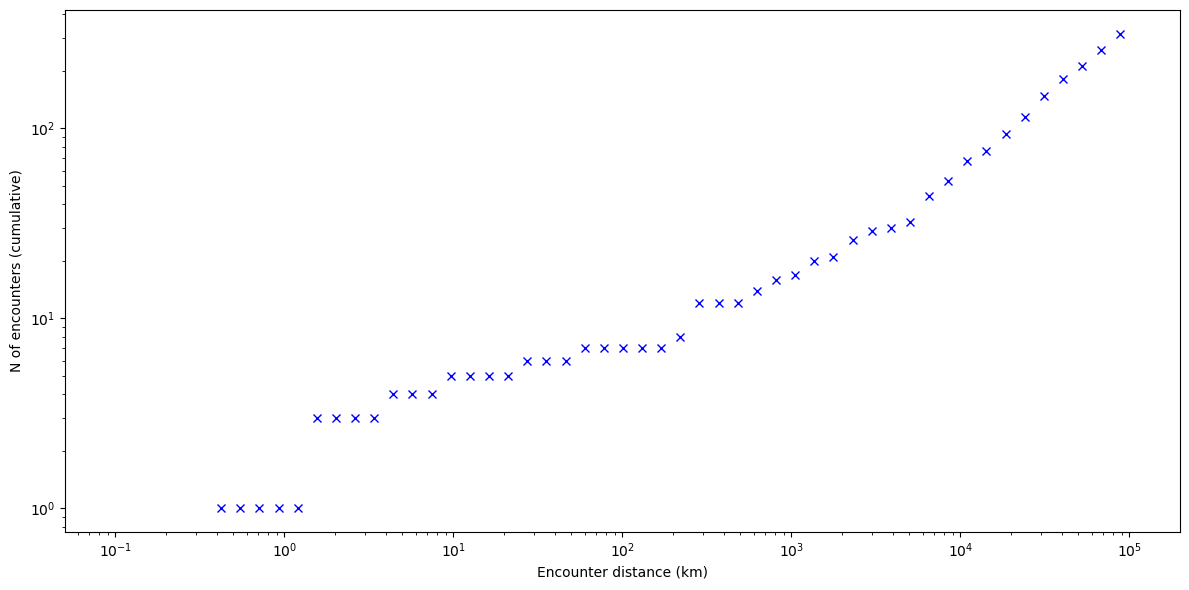

In [14]:
%matplotlib inline
from matplotlib.pylab import plt

fig = plt.figure(figsize=(12, 6))
plt.xscale('log')
plt.yscale('log')

logbins = np.logspace(-1, 5, 54)

vals, bin_edges, _ = plt.hist(ce_dist*149597900, cumulative=True, bins=logbins, histtype='step', edgecolor='None')
bin_centers = 0.5*(bin_edges[1:]+bin_edges[:-1])
plt.plot(bin_centers, vals , 'bx')
plt.xlabel("Encounter distance (km)")
plt.ylabel("N of encounters (cumulative)")

plt.tight_layout()

We can see how the closest encounter distance throughout the simulation was $\sim 400\,\mathrm{m}$. The cumulative number of close encounters seems to increase with a power law.

Let us now take a look at the evolution of the Heliocentric orbital elements:

In [11]:
# Extract the position and velocity vectors
# throughout the simulation.
out = out.reshape((-1, N_embryos + 1, 6))
out_r = out[:,:,0:3]
out_v = out[:,:,3:6]

# Compute the Heliocentric orbital elements
# of the embryos.
out_kep = []
for i in range(N_embryos):
    out_kep.append([pk.ic2par(r, v, G) for r, v in zip(out_r[:,i+1] - out[:,0,0:3], out_v[:,i+1] - out[:,0,3:6])])
out_kep = np.array(out_kep)

Here's the plot for the semi-major axes:

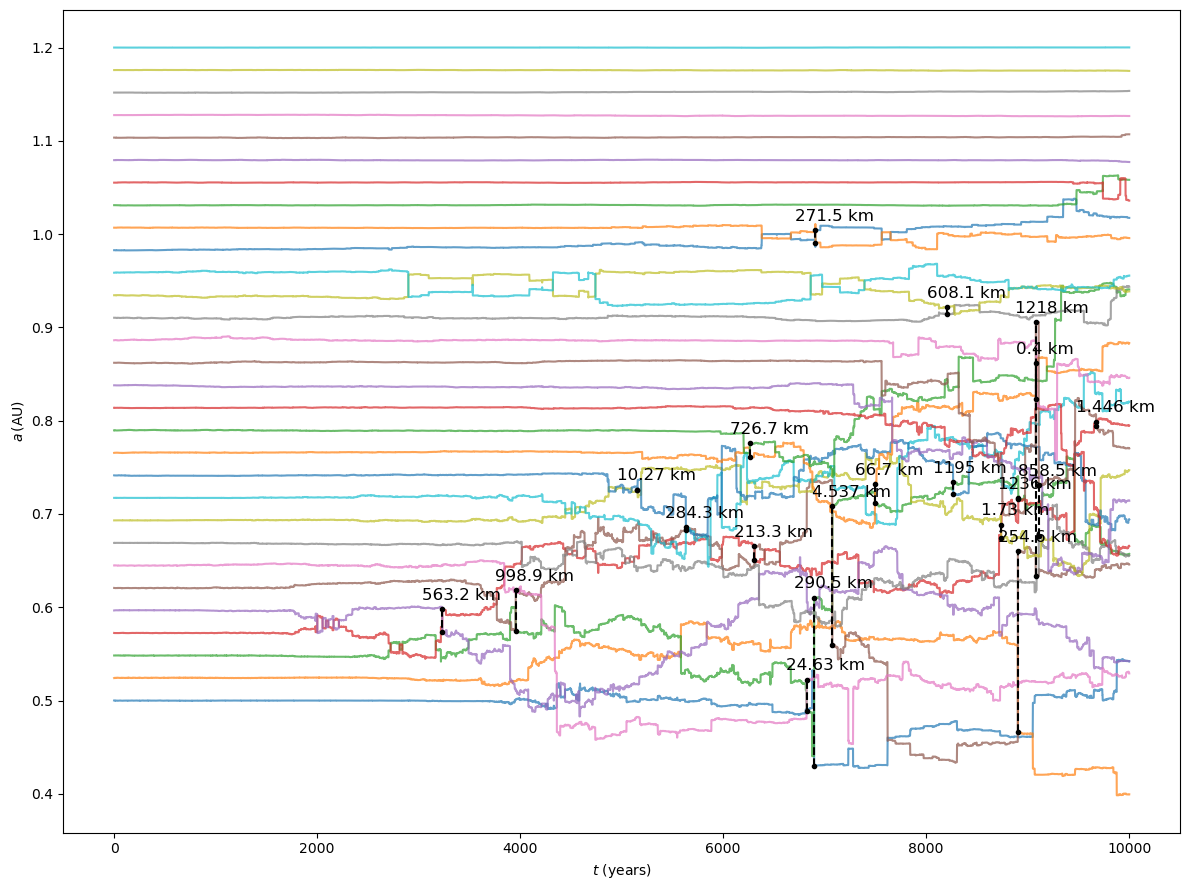

In [12]:
fig = plt.figure(figsize=(12, 9))

for i in range(N_embryos):
    plt.plot(t_grid, out_kep[i, :, 0], alpha=.7)

# Isolate the closest encounters.
ce_filt = list(filter(lambda t: t[-1] <= 1e-5, ce_list))

# Add them to the plot.
for tm, idx_i, idx_j, dist in ce_filt:
    tidx = t_grid.searchsorted(tm)
    ai = out_kep[idx_i - 1, tidx, 0]
    aj = out_kep[idx_j - 1, tidx, 0]
    xvals = [tm, tm]
    yvals = [ai, aj]
    plt.plot(xvals, yvals, 'ko--', markersize=3, zorder=150)
    plt.text(tm-200, max(yvals) + .01,
             '{:.4g} km'.format(dist*149597900), fontsize='large',
            zorder=200)

plt.xlabel("$t$ (years)")
plt.ylabel(r"$a\,\left(\mathrm{AU}\right)$")

plt.tight_layout()

In the plot we also added vertical dashed lines representing all encounters closer than $10^{-5}\,\mathrm{AU}$ (or $\sim 1500\,\mathrm{km})$. The lines begin and end in correspondence of the embryos involved in the encounter, and the text above the lines represents the encounter distance.

And here's the plot for the eccentricities:

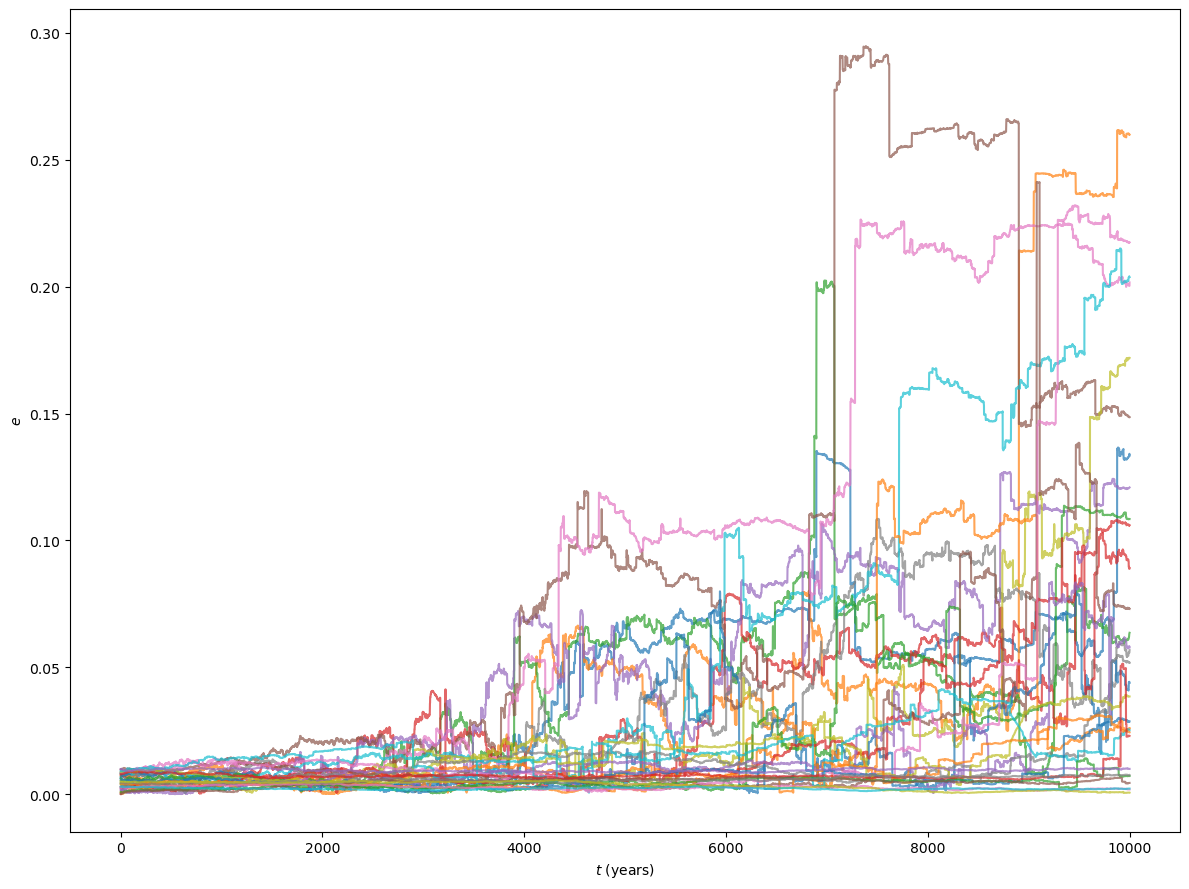

In [13]:
fig = plt.figure(figsize=(12, 9))

for i in range(N_embryos):
    plt.plot(t_grid, out_kep[i, :, 1], alpha=.7)

plt.xlabel("$t$ (years)")
plt.ylabel("$e$")

plt.tight_layout()

We can see how dynamical instabilities initially tend to involve pairs of embryos, but they can quickly propagate to embryos in adjacent orbits in a "domino effect" fashion.